<a href="https://colab.research.google.com/github/anishasahu/fem-helmholtz-eqn/blob/main/notebooks/1D_soln.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def create_mesh(N, L=1.0):
    """
    Create a 1D finite element mesh.

    Args:
      N (int): Number of elements
      L (float): Domain length

    Returns:
      tuple: Mesh info (h, nodes, elements)
    """
    h = L / N  # Element size
    nodes = np.linspace(0, L, N + 1)  # Node positions
    elements = np.array([[i, i + 1] for i in range(N)])  # Connectivity matrix
    return h, nodes, elements


# Define 1-point Gaussian quadrature rule
# This is used for numerical integration
gauss_point, gauss_weight = np.polynomial.legendre.leggauss(1)


def shape_functions(xi):
    """
    Compute linear basis functions in the reference element ξ in [-1,1].

    Args:
      xi (float): Reference coordinate in [-1,1].

    Returns:
      tuple: Basis functions and their derivatives in reference coordinates.
    """
    basis_fns = np.array([(1 - xi) / 2, (1 + xi) / 2])  # Basis functions ϕ1 and ϕ2
    dbasis_dxi = np.array([-0.5, 0.5])  # Derivatives w.r.t ξ
    return basis_fns, dbasis_dxi


def element_matrices(h, xi=gauss_point[0], w=gauss_weight[0]):
    """
    Compute the element stiffness and mass matrices using Gaussian quadrature.

    Args:
      h (float): Element size
      xi (float): Quadrature point in reference element
      w (float): Quadrature weight

    Returns:
      tuple: Element stiffness and mass matrices
    """
    Ke = np.zeros((2, 2))  # Element stiffness matrix
    Me = np.zeros((2, 2))  # Element mass matrix

    basis_fns, dbasis_dxi = shape_functions(xi)  # Get basis functions

    jacobian = h / 2  # Jacobian of transformation

    dbasis_dx = dbasis_dxi / jacobian  # Convert derivatives to physical space

    for i in range(2):
        for j in range(2):
            Ke[i, j] = dbasis_dx[i] * dbasis_dx[j] * jacobian * w
            Me[i, j] = basis_fns[i] * basis_fns[j] * jacobian * w

    return Ke, Me


def boundary_matrices(h, k, theta=0.0):
    """
    Compute boundary matrices for the Neumann and Sommerfeld boundary conditions.
    Args:
      h (float): Element size
      k (float): Wavenumber
      theta (float): Incident angle
    Returns:
      tuple: Neumann vector (N) and Sommerfeld matrix (S) for boundary elements
    """
    Ne = np.zeros(2, dtype=complex)  # Element Neumann condition matrix
    Se = np.zeros((2, 2), dtype=complex)  # Element Sommerfeld condition matrix

    # Incident derivative
    minus_du_in_dx = -1j * k * np.cos(theta)

    # Evaluate shape functions left boundary (ξ=-1)
    basis_at_left, _ = shape_functions(-1.0)

    # N_i = φ_i * ∂u_in/∂x * |J|
    # In 1D, |J| is just 1 at the boundary point
    for i in range(2):
        Ne[i] = basis_at_left[i] * minus_du_in_dx

    # Evaluate shape functions at right boundary (ξ=1)
    basis_at_right, _ = shape_functions(1.0)

    # S_ij = ik * φ_i * φ_j * |J|
    for i in range(2):
        for j in range(2):
            Se[i, j] = 1j * k * basis_at_right[i] * basis_at_right[j]

    return Ne, Se


def assembly(N: int, k: float, h: float, elements, theta=0.0):
    """
    Assemble the global system matrices for the Helmholtz equation.

    u'' + k²u = 0

    Args:
      N (int): Number of elements
      k (float): Wavenumber
      h (float): Element size
      elements (array): Element connectivity

    Returns:
      tuple: Assembled system matrix and RHS vector
    """
    n_nodes = N + 1  # Total number of nodes

    # Initialize global matrices and vectors
    K = np.zeros((n_nodes, n_nodes), dtype=complex)  # Global stiffness matrix
    M = np.zeros((n_nodes, n_nodes), dtype=complex)  # Global mass matrix
    S = np.zeros((n_nodes, n_nodes), dtype=complex)  # Global Sommerfeld boundary matrix
    b = np.zeros(n_nodes, dtype=complex)  # RHS vector including Neumann boundary term

    # Compute standard element matrices
    Ke, Me = element_matrices(h)

    # Assemble interior element contributions
    for e in range(N):
        nodes = elements[e]  # Get node indices for the element

        # Assemble global stiffness and mass matrices
        for i in range(2):
            for j in range(2):
                K[nodes[i], nodes[j]] += Ke[i, j]
                M[nodes[i], nodes[j]] += Me[i, j]

    # Get boundary matrices for Neumann (at x=0) and Sommerfeld (at x=L) conditions
    N_e, S_e = boundary_matrices(h, k, theta)

    # Apply Neumann boundary condition at x=0 (interior boundary, first element)
    first_element_nodes = elements[0]
    for i in range(2):
        b[first_element_nodes[i]] += N_e[i]

    # Apply Sommerfeld boundary condition at x=L (exterior boundary, last element)
    last_element_nodes = elements[-1]
    for i in range(2):
        for j in range(2):
            S[last_element_nodes[i], last_element_nodes[j]] += S_e[i, j]

    # Final system matrix: A = -K + k²M + S
    A = -K + (k**2) * M + S

    return A, b


def solve_helmholtz_fem(N, k, order=0, L=1.0):
    """
    Solve the 1D Helmholtz equation using FEM.

    Args:
      N (int): Number of elements
      k (float): Wavenumber
      L (float): Domain length

    Returns:
      tuple: Nodes and FEM solution
    """
    h, nodes, elements = create_mesh(N, L)  # Generate mesh
    A, b = assembly(N, k, h, elements)  # Assemble system matrices
    u = np.linalg.solve(A, b)  # Solve linear system
    return nodes, u


def analytical_solution(x, k):
    """
    Compute the analytical solution: u(x) = exp(ikx).

    Args:
      x (array): Spatial points
      k (float): Wavenumber

    Returns:
      array: Analytical solution values
    """
    return -np.exp(1j * k * x)


def plot_solution(x, u_num, k, L):
    """
    Plot the numerical and analytical solutions for comparison.

    Args:
      x (array): Spatial points
      u_num (array): Numerical FEM solution
      k (float): Wavenumber
      L (float): Domain length
    """
    x_fine = np.linspace(0, L, 1000)
    u_exact = analytical_solution(x_fine, k)

    plt.figure(figsize=(12, 5))

    plt.subplot(121)
    plt.plot(x_fine, u_exact.real, "r-", label="Analytical")
    plt.plot(x, u_num.real, "b--", label="FEM")
    plt.xlabel("x")
    plt.ylabel("Re(u)")
    plt.title(f"Real part (k={k})")
    plt.legend()
    plt.grid(True)

    plt.subplot(122)
    plt.plot(x_fine, u_exact.imag, "r-", label="Analytical")
    plt.plot(x, u_num.imag, "b--", label="FEM")
    plt.xlabel("x")
    plt.ylabel("Im(u)")
    plt.title(f"Imaginary part (k={k})")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def compute_L2_error(
    k, N, elements, nodes, u_num, gauss_points=gauss_point, gauss_weights=gauss_weight
):
    L2_error = 0.0

    for e in range(N):
        element = elements[e, :]
        nodal_coords = nodes[element]
        h = nodal_coords[-1] - nodal_coords[0]
        U = u_num[element]
        error = 0.0

        for i in range(len(gauss_points)):
            xi = gauss_points[i]
            wi = gauss_weights[i]
            basis_fns, dbasis_dxi = shape_functions(xi)
            x = np.dot(basis_fns, nodal_coords)
            Ue = np.dot(basis_fns, U)
            error += (analytical_solution(x, k) - Ue) ** 2 * h * wi

        L2_error += error

    return np.sqrt(L2_error)


def convergence_test(k_values, N_values, L=1.0):
    """
    Performs a convergence test for different values of k and N.
    Computes the numerical solution and compares it with the analytical solution.
    Plots the log-log error graph to analyze convergence behavior.

    Parameters:
    k_values (list): List of wave numbers to test.
    N_values (list): List of mesh refinements (number of elements).
    L (float, optional): Domain length scale (default is 1.0).
    """
    errors0 = {k: [] for k in k_values}
    # errors1 = {k: [] for k in k_values}
    # errors2 = {k: [] for k in k_values}
    h_values = []

    for N in N_values:
        h, nodes, elements = create_mesh(N)
        h_values.append(h)

        for i, k in enumerate(k_values):
            # Compute numerical solution
            nodes0, u_num0 = solve_helmholtz_fem(N, k, order=0)
            # nodes1, u_num1 = solve_helmholtz_fem(N, k, order=1)
            # nodes2, u_num2 = solve_helmholtz_fem(N, k, order=2)

            # Compute analytical solution
            u_exact = analytical_solution(nodes, k)

            # # Compute L2 error norm
            error0 = np.sqrt(compute_L2_error(k, N, elements, nodes, u_num0))
            # error1 = np.sqrt(compute_L2_error(k, N, elements, nodes, u_num1))
            # error2 = np.sqrt(compute_L2_error(k, N, elements, nodes, u_num2))
            errors0[k].append(error0)
            # errors1[k].append(error1)
            # errors2[k].append(error2)

    # Plot error curves for each k
    for k in k_values:
        log_h = np.log(h_values)
        log_error = np.log(errors0[k])
        slope, _ = np.polyfit(log_h, log_error, 1)
        print(f"Convergence rate for k = {k}: {slope:.2f}")
        plt.loglog(h_values, errors0[k], label=f"k = {k} (slope = {slope:.2f})")

    plt.xlabel("Element Size h")
    plt.ylabel("L2-norm Error")
    plt.title("Convergence Test: Log-Log Error Plot for Zeroth Order ABC")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

    # for k in k_values:
    #     log_h = np.log(h_values)
    #     log_error = np.log(errors1[k])
    #     slope, _ = np.polyfit(log_h, log_error, 1)
    #     print(f"Convergence rate for k = {k}: {slope:.2f}")
    #     plt.loglog(h_values, errors1[k], label=f'k = {k} (slope = {slope:.2f})')

    # plt.xlabel('Element Size h')
    # plt.ylabel('L2-norm Error')
    # plt.title('Convergence Test: Log-Log Error Plot for First Order ABC')
    # plt.legend()
    # plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    # plt.show()

    # for k in k_values:
    #     log_h = np.log(h_values)
    #     log_error = np.log(errors1[k])
    #     slope, _ = np.polyfit(log_h, log_error, 1)
    #     print(f"Convergence rate for k = {k}: {slope:.2f}")
    #     plt.loglog(h_values, errors1[k], label=f'k = {k} (slope = {slope:.2f})')

    # plt.xlabel('Element Size h')
    # plt.ylabel('L2-norm Error')
    # plt.title('Convergence Test: Log-Log Error Plot for 2nd Order ABC')
    # plt.legend()
    # plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    # plt.show()

Solving Helmholtz equation with:
Wavenumber k = 5
Domain length L = 2.0
Number of elements N = 100


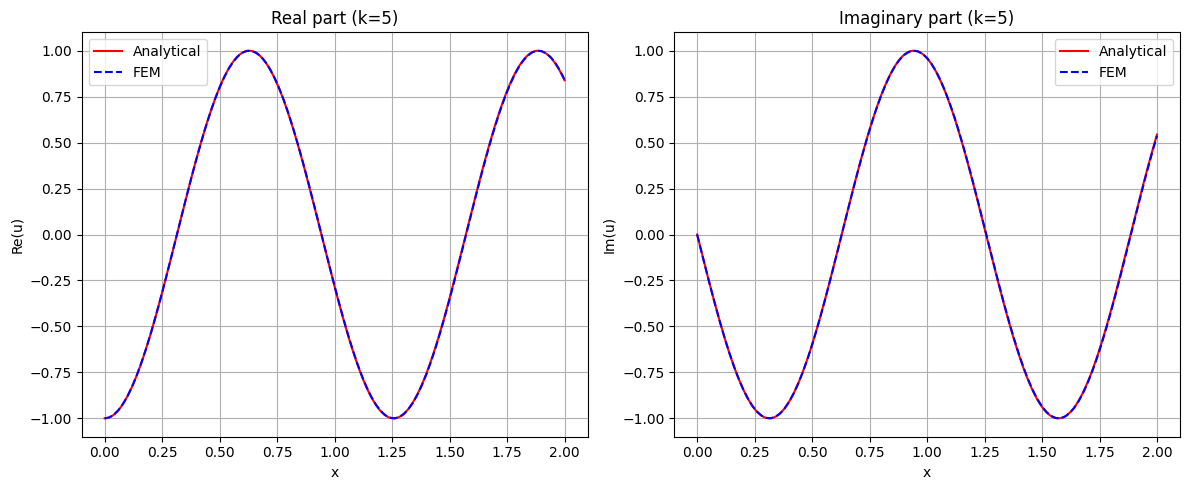

In [ ]:
# Parameters
k = 5  # Wavenumber
L = 2.0  # Domain length
N = 100  # Number of elements
print(f"Solving Helmholtz equation with:")
print(f"Wavenumber k = {k}")
print(f"Domain length L = {L}")
print(f"Number of elements N = {N}")
# Solve problem
x0, u0 = solve_helmholtz_fem(N, k, L=L, order=0)
# x1, u1 = solve_helmholtz_fem(N, k, L=L, order=1)
# x2, u2 = solve_helmholtz_fem(N, k, L=L, order=2)
# Plot solution
# print()
# print("Plot for Zeroth Order ABC")
plot_solution(x0, u0, k, L)
# print()
# print("Plot for First Order ABC")
# plot_solution(x1, u1, k, L)
# print()
# print("Plot for Second Order ABC")
# plot_solution(x2, u2, k, L)

Convergence rate for k = 1: 1.00-0.00j
Convergence rate for k = 5: 1.00-0.01j
Convergence rate for k = 10: 0.98-0.06j
Convergence rate for k = 15: 0.94-0.17j
Convergence rate for k = 30: 0.74+0.31j
Convergence rate for k = 100: 0.25-0.01j


/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


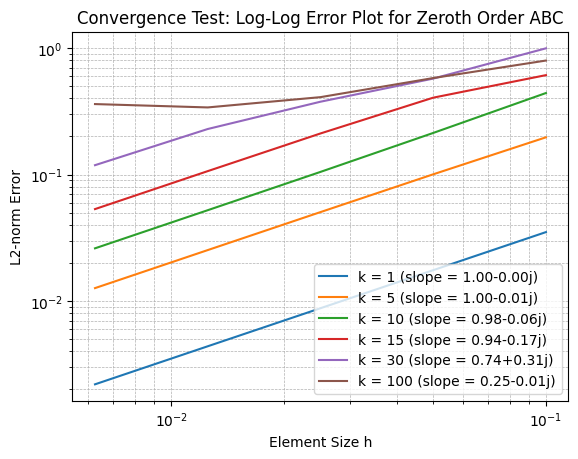

In [ ]:
N_values = [10, 20, 40, 80, 160]
k_values = [1, 5, 10, 15, 30, 100]
convergence_test(k_values, N_values)